# Benchmarking RL methods to solve BlackJack


Thomas Lemercier & Gaspard Berthelier

## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/RL/blackjack

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/blackjack


In [2]:
import gym
import time
from tqdm import tqdm
import numpy as np

In [47]:
from src.utils.general import state_to_index, get_num_states, state_to_tensor_encoding
from src.utils.data_struct import Transition
from src.agents import Agent
from src.utils.visualization import plot_policy_simple_blackjack


def play_episode(env: gym.Env, agent: Agent, render: bool = False, array_encoding: bool = False):
    """plays one episode of given agent"""
    state = env.reset()
    if render:
        env.render()
    if array_encoding:
        state = state_to_tensor_encoding(state, env.observation_space)
    else:
        state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        if array_encoding:
            next_state = state_to_tensor_encoding(next_state, env.observation_space)
        else:
            next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

In [48]:
def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int,  array_encoding: bool = False):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent, render= i == n_test_episodes-1, array_encoding=array_encoding) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [5]:
n_episodes = 500_000
n_test_episodes = 100_000

## Infinite Deck

Infinite deck, aka probabilities of drawing each card remains constant

In [6]:
from src.envs import InfiniteSimpleBlackjack
env = InfiniteSimpleBlackjack(seed=42)

### Random

Random agent which takes action randomly at each step

In [7]:
from src.agents import RandomAgent

agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, False)


Player's hand: [9, 10] (value: 19)
Dealer's hand: [8, 10] (value: 18)
Current state: [19  8  0]


Player's hand: [9, 10] (value: 19)
Dealer's hand: [8, 10] (value: 18)
Current state: [19  8  0]

Win rate: 0.2794
Draw rate: 0.0426


### Sarsa

In [8]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")

    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [9]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [01:47<00:00, 4639.74it/s]

Win rate: 0.3649
Draw rate: 0.0785

Time taken: 107.7775 seconds


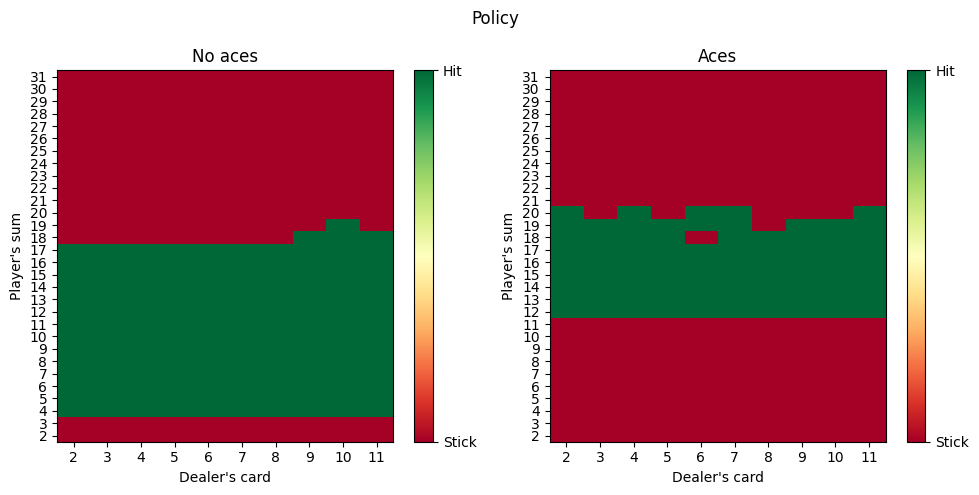


Player's hand: [5, 8] (value: 13)
Dealer's hand: [6, 10] (value: 16)
Current state: [13  6  0]


Player's hand: [5, 8, 11] (value: 14)
Dealer's hand: [6, 10] (value: 16)
Current state: [14  6  0]


Player's hand: [5, 8, 11, 4] (value: 18)
Dealer's hand: [6, 10] (value: 16)
Current state: [18  6  0]


Player's hand: [5, 8, 11, 4] (value: 18)
Dealer's hand: [6, 10, 5] (value: 21)
Current state: [18  6  0]

Win rate: 0.3603
Draw rate: 0.0769


In [10]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

In [11]:
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:46<00:00, 10695.04it/s]

Win rate: 0.3289
Draw rate: 0.0626

Time taken: 46.7555 seconds


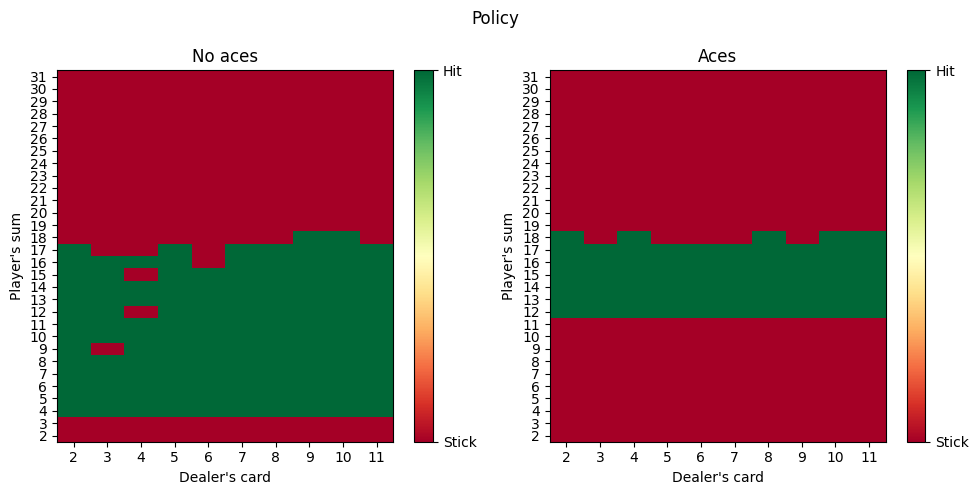


Player's hand: [7, 4] (value: 11)
Dealer's hand: [7, 7] (value: 14)
Current state: [11  7  0]


Player's hand: [7, 4, 10] (value: 21)
Dealer's hand: [7, 7] (value: 14)
Current state: [21  7  0]


Player's hand: [7, 4, 10] (value: 21)
Dealer's hand: [7, 7, 6] (value: 20)
Current state: [21  7  0]

Win rate: 0.3891
Draw rate: 0.0860


In [12]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

### Q Learning

In [13]:
from src.agents import QlearningAgent
from src.utils.data_struct import QlearningParameters

def main_qlearning(env: gym.Env, agent: QlearningAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")
    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [14]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [01:38<00:00, 5064.95it/s]

Win rate: 0.3621
Draw rate: 0.0784

Time taken: 98.7235 seconds


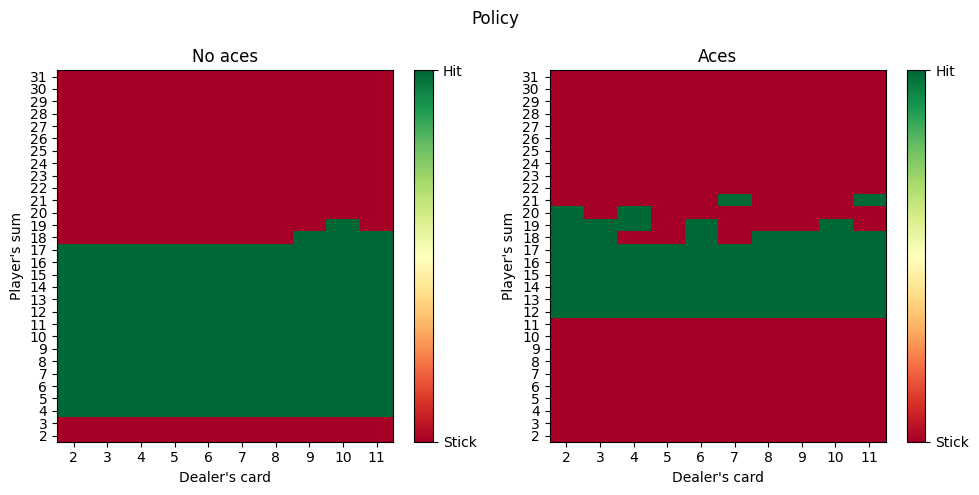


Player's hand: [4, 6] (value: 10)
Dealer's hand: [10, 7] (value: 17)
Current state: [10 10  0]


Player's hand: [4, 6, 9] (value: 19)
Dealer's hand: [10, 7] (value: 17)
Current state: [19 10  0]


Player's hand: [4, 6, 9, 10] (value: 29)
Dealer's hand: [10, 7] (value: 17)
Current state: [29 10  0]

Win rate: 0.3607
Draw rate: 0.0787


In [15]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

In [16]:
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:50<00:00, 9854.85it/s]

Win rate: 0.3218
Draw rate: 0.0573

Time taken: 50.7432 seconds


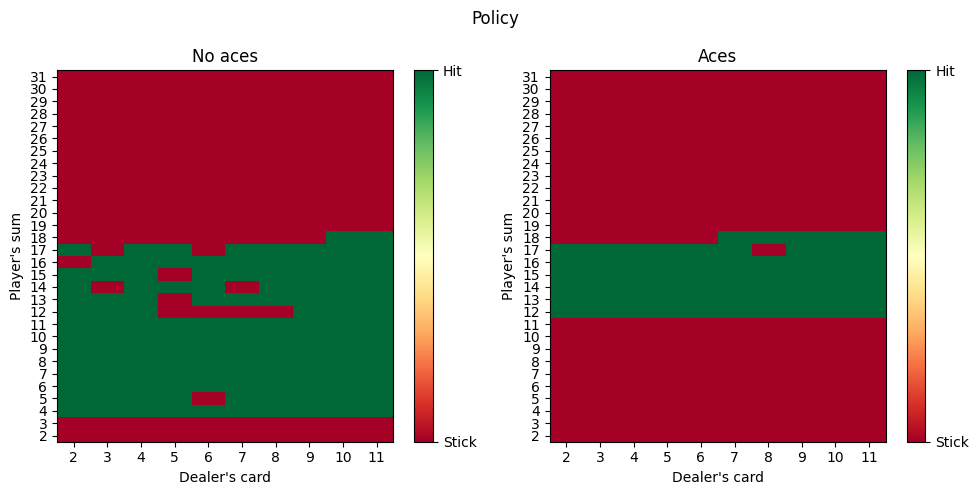


Player's hand: [6, 11] (value: 17)
Dealer's hand: [6, 7] (value: 13)
Current state: [17  6  1]


Player's hand: [6, 11, 5] (value: 12)
Dealer's hand: [6, 7] (value: 13)
Current state: [12  6  0]


Player's hand: [6, 11, 5] (value: 12)
Dealer's hand: [6, 7, 3, 5] (value: 21)
Current state: [12  6  0]

Win rate: 0.3913
Draw rate: 0.0826


In [17]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

## Simple Finite

In [18]:
from src.envs import SimpleBlackjack
env = SimpleBlackjack(seed=42, packs=4)

### Random

In [19]:
agent = RandomAgent(env.action_space, seed=42)
play_policy(env, agent, n_test_episodes)


Player's hand: [11, 2] (value: 13)
Dealer's hand: [10, 7] (value: 17)
Current state: [13 10  1  2]


Player's hand: [11, 2, 9] (value: 12)
Dealer's hand: [10, 7] (value: 17)
Current state: [12 10  0  3]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]

Win rate: 0.2791
Draw rate: 0.0414


### Sarsa

In [20]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [03:10<00:00, 2628.82it/s]

Win rate: 0.3669
Draw rate: 0.0769

Time taken: 190.2062 seconds


In [21]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [2, 6] (value: 8)
Dealer's hand: [8, 10] (value: 18)
Current state: [8 8 0 2]


Player's hand: [2, 6, 8] (value: 16)
Dealer's hand: [8, 10] (value: 18)
Current state: [16  8  0  3]


Player's hand: [2, 6, 8, 10] (value: 26)
Dealer's hand: [8, 10] (value: 18)
Current state: [26  8  0  4]

Win rate: 0.3684
Draw rate: 0.0777


In [22]:
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [02:00<00:00, 4155.96it/s]

Win rate: 0.3303
Draw rate: 0.0620

Time taken: 120.3177 seconds


In [23]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [11, 7] (value: 18)
Dealer's hand: [7, 3] (value: 10)
Current state: [18  7  1  2]


Player's hand: [11, 7] (value: 18)
Dealer's hand: [7, 3, 2, 10] (value: 22)
Current state: [18  7  1  2]

Win rate: 0.3841
Draw rate: 0.0800


### Q Learning

In [24]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [02:53<00:00, 2873.99it/s]

Win rate: 0.3715
Draw rate: 0.0799

Time taken: 173.9794 seconds


In [25]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 3] (value: 13)
Dealer's hand: [10, 5] (value: 15)
Current state: [13 10  0  2]


Player's hand: [10, 3, 5] (value: 18)
Dealer's hand: [10, 5] (value: 15)
Current state: [18 10  0  3]


Player's hand: [10, 3, 5, 8] (value: 26)
Dealer's hand: [10, 5] (value: 15)
Current state: [26 10  0  4]

Win rate: 0.3656
Draw rate: 0.0793


In [26]:
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [02:08<00:00, 3901.35it/s]

Win rate: 0.3223
Draw rate: 0.0577

Time taken: 128.1679 seconds


In [27]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [7, 10] (value: 17)
Dealer's hand: [5, 4] (value: 9)
Current state: [17  5  0  2]


Player's hand: [7, 10] (value: 17)
Dealer's hand: [5, 4, 10] (value: 19)
Current state: [17  5  0  2]

Win rate: 0.3943
Draw rate: 0.0832


## Complete

In [49]:
from src.envs import Blackjack
env = Blackjack(seed=42, packs=4)

### Random

In [50]:
from src.agents import RandomAgent

agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, False)

AttributeError: 'Dict' object has no attribute 'low'

### DQN

In [29]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [30]:
n_episodes = 100_000

In [31]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 100000/100000 [06:40<00:00, 249.44it/s]

Win rate: 0.32
Draw rate: 0.05

Time taken: 400.90 seconds


In [32]:
play_policy(env, agent, n_test_episodes, array_encoding=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Player's hand: [11, 8] (value: 19)
Dealer's hand: [4, 9] (value: 13)
Current state: {'dealer': 4, 'player': [11, 8]}


Player's hand: [11, 8] (value: 19)
Dealer's hand: [4, 9, 3, 10] (value: 26)
Current state: {'dealer': 4, 'player': [11, 8]}

Win rate: 0.3828
Draw rate: 0.0621


In [35]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

play_policy(env, agent, n_test_episodes, array_encoding=True)

AttributeError: 'Dict' object has no attribute 'high'

### DQN sequence

In [39]:
from src.utils.general import state_to_tensor_sequence

def main(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

In [37]:
params = DQNParameters()
q_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main(env, agent, n_episodes)

100%|██████████| 100000/100000 [05:27<00:00, 305.38it/s]

Win rate: 0.38
Draw rate: 0.06

Time taken: 327.47 seconds


AttributeError: 'Dict' object has no attribute 'low'

In [40]:
n_test_episodes = 10000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4111
Draw rate: 0.0665


### DQN encoding

In [41]:
params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 100000/100000 [05:40<00:00, 293.45it/s]


Win rate: 0.37
Draw rate: 0.05

Time taken: 340.78 seconds


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x23 and 11x64)

In [42]:
def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_encoding(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_encoding(next_state, env.observation_space)
        state = next_state
    return reward

In [43]:
n_test_episodes = 10000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.3786
Draw rate: 0.0559


### DQN embedding

In [44]:
from src.networks import MLPEmbedding

input_range = env.observation_space["dealer"].high.item() - env.observation_space["dealer"].low.item() + 1

params = DQNParameters(device=torch.device("cpu"))
q_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

n_test_episodes = 10_000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 100000/100000 [11:21<00:00, 146.70it/s]


Win rate: 0.06
Draw rate: 0.01

Time taken: 681.69 seconds
Win rate: 0.0102
Draw rate: 0.0017
